# Ejercicio 02 - aliasing_new.m

### Cargamos la imagen de prueba

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import cv2 as cv

In [4]:
from scipy.fft import fft2,fftshift

In [18]:
img = cv.imread('../resource/barbara.tif', cv.IMREAD_GRAYSCALE)
(y_size, x_size) = img.shape

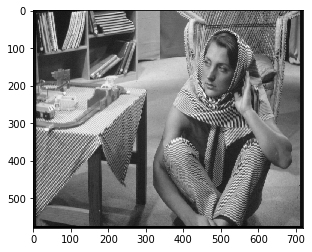

In [14]:
plt.imshow(img, cmap='gray')
plt.show()

In [7]:
# Video de salida
fourcc = cv.VideoWriter_fourcc('M','J','P','G')
aliased_out = cv.VideoWriter("../resource/aliased_barbara.mp4",fourcc,20.0,img.shape)
# spectrum_out = cv.VideoWriter("../resource/spectrum.mp4",fourcc,20.0,img.shape)

## Aplicación de la transformación afín
Se utilizará la transformación afín para escalar la imagen a una menor resolución y luego reescalarla a su tamaño original. Para escalar la imagen en un factor $\gamma$, la matriz de transformación resulta:

\begin{pmatrix}
\gamma & 0 & 0 \\ 
0 & \gamma & 0 \\ 
0 & 0 & 1
\end{pmatrix}

Se variará $\gamma$ entre 1, mismo tamaño, y 0.16, es decir, dimensiones 16% del tamaño original.

In [8]:
N = 600
step = 5
imgs = np.zeros((round(N/step), y_size, x_size))
spectrums = np.zeros((round(N/step), y_size, x_size))

In [9]:
for x_shrink in range(0,N,step):
    desired_xsize = x_size - x_shrink
    sh_factor = desired_xsize / x_size

    T1 = np.asarray(
            [[sh_factor, 0, 0 ],
             [0, sh_factor, 0 ]])
    img2 = cv.warpAffine(img, T1, (img.shape[1], img.shape[0]))

    curr_xsize = round(sh_factor * x_size)
    sc_factor = x_size / curr_xsize
    
    T2 = np.asarray(
            [[sc_factor, 0, 0 ],
             [0, sc_factor, 0 ]])
    img3 = cv.warpAffine(img2, T2, (img.shape[1], img.shape[0]))
    
    Fd = fftshift(np.log(1+np.abs(fft2(img3))))
    
    imgs[int(round(x_shrink/step)),:,:] = img3
    spectrums[int(round(x_shrink/step)),:,:] = cv.normalize(Fd, Fd)

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [11]:
# To make the animation work, install ffmpeg and run this cell with the appropiate path (no spaces)
# https://stackoverflow.com/questions/32032543/how-can-i-overcome-this-key-word-error
plt.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'

In [19]:
# np array with shape (frames, height, width)
fig = plt.figure()
im = plt.imshow(imgs[0,:,:], cmap='gray')

plt.axis('off')
plt.close() # this is required to not display the generated image
def init():
    im.set_data(imgs[0,:,:])

def animate(i):
    im.set_data(imgs[i,:,:])
    fig.suptitle(f'Factor de escalamiento $\gamma$: {1 - (i * 5 / 720):.2f}')
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=imgs.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

## Observaciones temporales
Se puede observar que a medida que disminuye $\gamma$ aparece un efecto de aliasing cada vez mayor, de la misma forma que en el "viasampling.m". Se aprecia una modulación de baja frecuencia sobre la imagen original. 
Al igual que en "viasampling.m", el aliasing podría ser evitado utilizando un filtro pasabajos antes de realizar la transformación.

In [20]:
import matplotlib.patches as patches

In [37]:
# np array with shape (frames, height, width)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = plt.imshow(spectrums[0,:,:], cmap='gray',extent=[-1/2, 1/2, 1/2, -1/2])

# plot rectangle
rect = patches.Rectangle((-1/4, -1/4), 1/2, 1/2, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.close() # this is required to not display the generated image
def init():
    im.set_data(spectrums[0,:,:])

def animate(i):
    gamma = 1 - (i * 5 / 720)
    im.set_data(spectrums[i,:,:])
    fig.suptitle(f'Factor de escalamiento $\gamma$: {gamma:.2f}')
    ax.patches = []
    rect = patches.Rectangle((-gamma/2,-gamma/2), gamma, gamma, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=spectrums.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

## Obersvaciones espectrales
La presencia de aliasing se valida obervando que el espectro tiene componentes en $f > \gamma$, marcado por el cuadrado superpuesto en el gráfico. Cuando $\gamma = 1$, no hay espectro fuera del rectángulo, y cuanto menor es $\gamma$, más espectro hay fuera, provocando más alias. <br>
Además, hacia el final de la animación se puede ver la periodicidad del espectro.